---

### 🎓 **Professor**: Apostolos Filippas

### 📘 **Class**: AI Engineering

### 📋 **Homework 3**: Improving Lexical Search

### 📅 **Due Date**: Day of Lecture 4, 11:59 PM


**Note**: You are not allowed to share the contents of this notebook with anyone outside this class without written permission by the professor.

---

You'll apply what we covered in Lecture 3 (Lexical Search & BM25) to a real e-commerce search problem using the **WANDS dataset** 
- WANDS stands for Wayfair Annotated Dataset. It's a dataset of furniture products and search queries, along with human relevance judgments.

You will:
1. **Build a search engine** from scratch using BM25.
2. **Learn how to evaluate search results** using NDCG — a metric for measuring search quality
3. **Attempt to improve your search engine** by adding multiple fields
4. **Use LLMs to improve your search engine** by adding simple query understanding

Yes, *you* will do all these things. Let's go!

---

## Task 1: Environment Setup

First, let's set up your environment and verify everything works.

### 1a. Install dependencies and verify imports

Run `uv add pystemmer` in your terminal to add the Snowball stemmer. Then run the cell below to verify all imports work.

In [4]:
%pip install pandas numpy pystemmer litellm pydantic python-dotenv

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/9.7 MB ? eta -:--:--
   ----- ---------------------------------- 1.3/9.7 MB 8.4 MB/s eta 0:00:02
   -------- ------------------------------- 2.1/9.7 MB 5.6 MB/s eta 0:00:02
   ---------- ----------------------------- 2.6/9.7 MB 4.4 MB/s eta 0:00:02
   ----------------- ---------------------- 4.2/9.7 MB 5.2 MB/s eta 0:00:02
   ---------------------------- ----------- 6.8/9.7 MB 6.8 MB/s eta 0:00:01
   ---------------------------------------  9.7/9.7 MB 7.9 MB/s eta 0:00:01
   ---------------------------------------- 9.7/9.7 MB 7.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 26.0
[notice] To update, run: C:\Users\DELL\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [5]:
# Task 1a: Verify imports work
import pandas as pd
import numpy as np
from collections import Counter
import string
from pathlib import Path
# a stemmer from `pystemmer` for better tokenization
import Stemmer 
# llm packages
import litellm
from pydantic import BaseModel, Field
from typing import Optional
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Pandas display settings
# pd.set_option('display.max_colwidth', 100)

# Ignore pydantic warnings for litellm
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pydantic")

print("All imports successful!")

All imports successful!


### 1b. Verify API keys

Test that your API keys work by making a simple call.

In [6]:
# Task 1b: Verify API keys
response = litellm.completion(
    model="gpt-4o-mini",
    messages=[{"role": "user", "content": "Say 'API working!' and nothing else."}],
    max_tokens=20
)
print(response.choices[0].message.content)

API working!


---

## Task 2: Load and Explore the WANDS Dataset

The **WANDS dataset** (Wayfair Annotated Dataset) contains:
- 43K furniture products from Wayfair
- 480 real search queries
- 233K human relevance judgments (query-product pairs)

This is a real-world search benchmark used to evaluate e-commerce search systems!

**Data Source**: [WANDS on GitHub](https://github.com/wayfair/WANDS)

The data files are pre-downloaded in the `data/` directory:
- `wayfair-products.csv` - Product catalog
- `wayfair-queries.csv` - Search queries
- `wayfair-labels.csv` - Relevance judgments

### Data Loading Functions (provided)

Run the cell below to define the loading functions.

In [7]:
# Data loading functions (provided)
# Note: Data from WANDS (Wayfair Annotated Dataset)
# Source: https://github.com/wayfair/WANDS

def load_wands_products(data_dir: str = "../data") -> pd.DataFrame:
    """
    Load WANDS products from local file.
    
    Args:
        data_dir: Path to the data directory containing wayfair-products.csv
        
    Returns:
        DataFrame with product information including product_id, product_name,
        product_class, category_hierarchy, product_description, etc.
    """
    filepath = Path(data_dir) / "wayfair-products.csv"
    products = pd.read_csv(filepath, sep='\t')
    products = products.rename(columns={'category hierarchy': 'category_hierarchy'})
    return products

def load_wands_queries(data_dir: str = "../data") -> pd.DataFrame:
    """
    Load WANDS queries from local file.
    
    Args:
        data_dir: Path to the data directory containing wayfair-queries.csv
        
    Returns:
        DataFrame with query_id and query columns
    """
    filepath = Path(data_dir) / "wayfair-queries.csv"
    queries = pd.read_csv(filepath, sep='\t')
    return queries

def load_wands_labels(data_dir: str = "../data") -> pd.DataFrame:
    """
    Load WANDS relevance labels from local file.
    
    Args:
        data_dir: Path to the data directory containing wayfair-labels.csv
        
    Returns:
        DataFrame with query_id, product_id, label (Exact/Partial/Irrelevant),
        and grade (2/1/0) columns
    """
    filepath = Path(data_dir) / "wayfair-labels.csv"
    labels = pd.read_csv(filepath, sep='\t')
    grade_map = {'Exact': 2, 'Partial': 1, 'Irrelevant': 0}
    labels['grade'] = labels['label'].map(grade_map)
    return labels

print("Loading functions defined!")

Loading functions defined!


### 2a. Load the data

Use the provided functions to load all three datasets. Print the number of rows in each.

In [3]:
import pandas as pd
import os

def load_csv_safe(path, filename):
    return pd.read_csv(
        os.path.join(path, filename),
        engine="python",        # tolerant parser
        on_bad_lines="skip"     # skip bad rows instead of crashing
    )

def load_wands_products(path):
    return load_csv_safe(path, "product.csv")

def load_wands_queries(path):
    return load_csv_safe(path, "query.csv")

def load_wands_labels(path):
    return load_csv_safe(path, "label.csv")


In [4]:
# Task 2a: Load the data
# Task 2a: Load the data
products = load_wands_products("data")
queries  = load_wands_queries("data")
labels   = load_wands_labels("data")

print("Products rows:", len(products))
print("Queries rows:", len(queries))
print("Labels rows:", len(labels))



Products rows: 39859
Queries rows: 474
Labels rows: 233448


### 2b. Explore products

List the available columns, and display a few sample products. 

Which columns might be useful for search?

In [5]:
# YOUR CODE HERE# Show all column names in the products dataset
print(products.columns)



Index(['product_id\tproduct_name\tproduct_class\tcategory hierarchy\tproduct_description\tproduct_features\trating_count\taverage_rating\treview_count'], dtype='str')


In [6]:
# YOUR CODE HERE
# Display first 5 products
products.head()


,,,,,,,,,,product_id\tproduct_name\tproduct_class\tcategory hierarchy\tproduct_description\tproduct_features\trating_count\taverage_rating\treview_count
0\tsolid wood platform bed\tBeds\tFurniture / Bedroom Furniture / Beds & Headboards / Beds / Twin Beds\tgood,deep sleep can be quite difficult to have in this busy age . fortunately,there ’ s an antidote to such a problem : a nice,quality bed frame like the acacia kaylin . solidly constructed from acacia wood,this bed frame will stand the test of time and is fit to rest your shoulders on for years and years . its sleek,natural wood grain appearance provides a pleasant aesthetic to adorn any bedroom,acting both as a decorative piece as well as a place to give comfort after a hard day of work . our bed frame is designed to give ample under-bed space for easy cleaning and other usages,with a headboard attached to further express the craftiness . it can be used with other accessories such as a nightstand or bookcase headboard and is compatible with many types of mattresses including memory foam,spring,or hybrid ones . there ’ s nowhere better to relax than your own home,and with this bed frame that feeling of homel...
1\tall-clad 7 qt . slow cooker\tSlow Cookers\tKitchen & Tabletop / Small Kitchen Appliances / Pressure & Slow Cookers / Slow Cookers / Slow Slow Cookers\tcreate delicious slow-cooked meals,from tender meat to flavorful veggies,with this easy-to-use slow cooker . the unit features a nonstick cast-aluminum insert that moves seamlessly from the oven or stovetop to the electric base to the table . you can use the insert alone or with the slow cooker to make a variety of one-pot dishes from soup to desserts,and much more . you can even prepare your ingredients in the morning,place everything in the slow cooker,and walk away to come home to the aroma of a hot,healthy dinner at the end of a busy day . with its sleek stainless-steel finish,the slow cooker not only presents beautifully,but it ’ s also the perfect size to accommodate the whole family or a large group when entertaining .\tcapacityquarts:7|producttype : slow cooker|programmablecookingsettings : slow cook|overallheight-toptobottom:14.2|overalldepth-fronttoback:11.3|programmablefoodsettings : soup|overallwidth-sidetoside:19.9|topprogrammablesettings : soup & stew|programmablecookingsettings : keep warm|dishwashersafeparts : cooking pot/insert|dishwashersafeparts : lid|features : non-stick|housingheatingbasematerial : stainless steel|cookingpotinsertmaterial : aluminum|features : automatic shutoff|operationtype : programmable|finish : white|overallproductweight:13|programmablefoodsettings : stew|features : adjustable temperature settings| : no|uniformpackagingandlabelingregulationsuplrcompliant : no|commercialwarranty : no|indicatorlight : yes|removablecookingpotinsert : yes|programmable : yes|countryoforigin : china|supplierintendedandapproveduse : residential use\t100.0\t2.0\t98.0,nan,NaN
2\tall-clad electrics 6.5 qt . slow cooker\tSlow Cookers\tKitchen & Tabletop / Small Kitchen Appliances / Pressure & Slow Cookers / Slow Cookers / Slow Slow Cookers\tprepare home-cooked meals on any schedule with this essential slow cooker,featuring a dishwasher-safe insert and 26-hour timer .\tfeatures : keep warm setting|capacityquarts:6.5|programmablefoodsettings : soup|warrantylength:1 year| : slow cooker,lid and insert|features : adjustable temperature settings|features : portable|overallproductweight:18|cookedriceyieldcups:26|housingheatingbasematerial : stainless steel|programmablecookingsettings : keep warm|programmablecookingsettings : slow cook|overalldepth-fronttoback:14|overallwidth-sidetoside:19.88|dishwashersafeparts : cooking pot/insert|features : timer|topprogrammablesettings : warm,high,low|features : cool-touch exterior|features : non-stick|cookingpotinsertmaterial : ceramic|wattage:320|producttype : slow cooker|dishwashersafeparts : lid|operationtype : programmable|finish : stainless steel|programmablefoodsett

In [7]:
# YOUR CODE HERE# Likely useful columns for search relevance
useful_cols = [
    "product_title",
    "product_description",
    "product_brand",
    "product_color"
]

print("Useful columns for search:")
print(useful_cols)



Useful columns for search:
['product_title', 'product_description', 'product_brand', 'product_color']


### 2c. Understand relevance judgments

The `labels` dataset contains human judgments of relevance. In particular, for each query-product pair, it contains:
| Label        | Grade | Description                                 |
|--------------|-------|---------------------------------------------|
| Exact        |   2   | This product is exactly what the user wants |
| Partial      |   1   | This product is somewhat relevant           |
| Irrelevant   |   0   | This product doesn't match the query        |

First, let's look at the distribution of grades.

In [18]:
# Distribution (count) of relevance grades
grade_col = labels.columns[-1]   # last column is the relevance column
labels[grade_col].value_counts()




id\tquery_id\tproduct_id\tlabel
0\t0\t25434\tExact                1
1\t0\t12088\tIrrelevant           1
2\t0\t42931\tExact                1
3\t0\t2636\tExact                 1
4\t0\t42923\tExact                1
                                 ..
234010\t478\t15439\tPartial       1
234011\t478\t451\tPartial         1
234012\t478\t30764\tIrrelevant    1
234013\t478\t16796\tPartial       1
234014\t486\t30764\tPartial       1
Name: count, Length: 233448, dtype: int64

In [20]:
# Percentage distribution of relevance grades
grade_col = labels.columns[-1]
labels[grade_col].value_counts(normalize=True) * 100


id\tquery_id\tproduct_id\tlabel
0\t0\t25434\tExact                0.000428
1\t0\t12088\tIrrelevant           0.000428
2\t0\t42931\tExact                0.000428
3\t0\t2636\tExact                 0.000428
4\t0\t42923\tExact                0.000428
                                    ...   
234010\t478\t15439\tPartial       0.000428
234011\t478\t451\tPartial         0.000428
234012\t478\t30764\tIrrelevant    0.000428
234013\t478\t16796\tPartial       0.000428
234014\t486\t30764\tPartial       0.000428
Name: proportion, Length: 233448, dtype: float64

---
## Task 3: Build and Run BM25 Search

Now let's build a BM25 search engine! We'll use the same concepts from Lecture 3.

### Provided Functions

We're giving you these functions to work with. Run the next cell to define them, then look at the examples.

| Function | What it does |
|----------|--------------|
| `snowball_tokenize(text)` | Tokenizes text, removes punctuation, stems words |
| `build_index(docs, tokenizer)` | Builds an inverted index from a list of documents |
| `get_tf(term, doc_id, index)` | Gets term frequency for a term in a document |
| `get_df(term, index)` | Gets document frequency for a term (how many docs contain the term) |
| `bm25_idf(df, num_docs)` | Calculates the IDF component of BM25 |
| `bm25_tf(tf, doc_len, avg_doc_len)` | Calculates the TF normalization for BM25 |
| `score_bm25(query, index, ...)` | Scores all documents for a query using BM25 |
| `search_products(query, ...)` | Searches and returns top-k results |

In [30]:
# ONE BIG FIX CELL: installs missing packages + imports + defines stemmer safely

import sys
import subprocess

def pip_install(pkg):
    subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

# 1) Install PyStemmer (for `import Stemmer`)
try:
    import Stemmer
except ModuleNotFoundError:
    pip_install("PyStemmer")
    import Stemmer

# 2) Standard imports needed by the provided functions cell
import string

# 3) Create the stemmer + punctuation translation (exactly like the notebook expects)
stemmer = Stemmer.Stemmer("english")
punct_trans = str.maketrans({ch: " " for ch in string.punctuation})

print("✅ Setup complete.")
print("Stemmer type:", type(stemmer))
print("Example punctuation translation ready.")


✅ Setup complete.
Stemmer type: <class 'Stemmer.Stemmer'>
Example punctuation translation ready.


In [33]:
# Install missing packages if needed
import sys, subprocess

def pip_install(pkg):
    subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

# NumPy (for np.ndarray etc.)
try:
    import numpy as np
except ModuleNotFoundError:
    pip_install("numpy")
    import numpy as np

# PyStemmer (for Stemmer.Stemmer)
try:
    import Stemmer
except ModuleNotFoundError:
    pip_install("PyStemmer")
    import Stemmer

# Standard libraries used later
import string
import math
from collections import defaultdict

print("All dependencies loaded successfully.")


All dependencies loaded successfully.


In [34]:
# Provided functions - run this cell to define them

stemmer = Stemmer.Stemmer('english')
punct_trans = str.maketrans({key: ' ' for key in string.punctuation})

def snowball_tokenize(text: str) -> list[str]:
    """
    Tokenize text with Snowball stemming.
    
    Args:
        text: The text to tokenize
        
    Returns:
        List of stemmed tokens
    """
    if pd.isna(text) or text is None:
        return []
    text = str(text).translate(punct_trans)
    tokens = text.lower().split()
    return [stemmer.stemWord(token) for token in tokens]

def build_index(docs: list[str], tokenizer) -> tuple[dict, list[int]]:
    """
    Build an inverted index from a list of documents.
    
    Args:
        docs: List of document strings to index
        tokenizer: Function that takes text and returns list of tokens
        
    Returns:
        index: dict mapping term -> {doc_id: term_count}
        doc_lengths: list of document lengths (in tokens)
    """
    index = {}
    doc_lengths = []
    
    for doc_id, doc in enumerate(docs):
        tokens = tokenizer(doc)
        doc_lengths.append(len(tokens))
        term_counts = Counter(tokens)
        
        for term, count in term_counts.items():
            if term not in index:
                index[term] = {}
            index[term][doc_id] = count
    
    return index, doc_lengths

def get_tf(term: str, doc_id: int, index: dict) -> int:
    """
    Get term frequency for a term in a document.
    
    Args:
        term: The term to look up
        doc_id: The document ID
        index: The inverted index
        
    Returns:
        Term frequency (count), or 0 if not found
    """
    if term in index and doc_id in index[term]:
        return index[term][doc_id]
    return 0

def get_df(term: str, index: dict) -> int:
    """
    Get document frequency for a term.
    
    Args:
        term: The term to look up
        index: The inverted index
        
    Returns:
        Number of documents containing the term
    """
    if term in index:
        return len(index[term])
    return 0

def bm25_idf(df: int, num_docs: int) -> float:
    """
    BM25 IDF formula.
    
    Args:
        df: Document frequency
        num_docs: Total number of documents
        
    Returns:
        IDF score
    """
    return np.log((num_docs - df + 0.5) / (df + 0.5) + 1)

def bm25_tf(tf: int, doc_len: int, avg_doc_len: float, k1: float = 1.2, b: float = 0.75) -> float:
    """
    BM25 TF normalization.
    
    Args:
        tf: Term frequency
        doc_len: Document length in tokens
        avg_doc_len: Average document length
        k1: Saturation parameter (default 1.2)
        b: Length normalization (default 0.75)
        
    Returns:
        Normalized TF score
    """
    return (tf * (k1 + 1)) / (tf + k1 * (1 - b + b * doc_len / avg_doc_len))

def score_bm25(query: str, index: dict, num_docs: int, doc_lengths: list[int], 
               tokenizer, k1: float = 1.2, b: float = 0.75) -> np.ndarray:
    """
    Score all documents using BM25.
    
    Args:
        query: The search query
        index: Inverted index
        num_docs: Total number of documents
        doc_lengths: List of document lengths
        tokenizer: Tokenization function
        
    Returns:
        Array of scores for each document
    """
    query_tokens = tokenizer(query)
    scores = np.zeros(num_docs)
    avg_doc_len = np.mean(doc_lengths) if doc_lengths else 1.0
    
    for token in query_tokens:
        df = get_df(token, index)
        if df == 0:
            continue
        
        idf = bm25_idf(df, num_docs)
        
        if token in index:
            for doc_id, tf in index[token].items():
                tf_norm = bm25_tf(tf, doc_lengths[doc_id], avg_doc_len, k1, b)
                scores[doc_id] += idf * tf_norm
    
    return scores

def search_products(query: str, products_df: pd.DataFrame, index: dict, 
                    doc_lengths: list[int], tokenizer, k: int = 10) -> pd.DataFrame:
    """
    Search products and return top-k results.
    
    Args:
        query: The search query
        products_df: DataFrame of products
        index: Inverted index
        doc_lengths: Document lengths
        tokenizer: Tokenization function
        k: Number of results to return
        
    Returns:
        DataFrame with top-k products and scores
    """
    scores = score_bm25(query, index, len(products_df), doc_lengths, tokenizer)
    top_k_idx = np.argsort(-scores)[:k]
    
    results = products_df.iloc[top_k_idx].copy()
    results['score'] = scores[top_k_idx]
    results['rank'] = range(1, k + 1)
    return results

print("All functions defined!")

All functions defined!


In [36]:
# --- FIX MISSING LIBRARIES ---

import sys, subprocess

def pip_install(pkg):
    subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

# Fix NumPy (for np)
try:
    import numpy as np
except ModuleNotFoundError:
    pip_install("numpy")
    import numpy as np

# Fix Stemmer (PyStemmer)
try:
    import Stemmer
except ModuleNotFoundError:
    pip_install("PyStemmer")
    import Stemmer

# Other required imports
import string
import math
from collections import defaultdict

print("✅ Libraries fixed. You can run the BM25 functions now.")


✅ Libraries fixed. You can run the BM25 functions now.


In [39]:
# --- FIX MISSING IMPORTS ---

# NumPy (for np)
import numpy as np

# PyStemmer (for Stemmer.Stemmer)
import Stemmer

# Standard libraries
import string
import math

# Collections tools used inside functions
from collections import defaultdict, Counter

print("All required imports loaded successfully.")


All required imports loaded successfully.


In [40]:
# Examples of each function

# 1. snowball_tokenize - tokenizes and stems text
print("1. snowball_tokenize('Running shoes are amazing!')")
print(f"   -> {snowball_tokenize('Running shoes are amazing!')}")
print("   Notice: 'Running' -> 'run', 'shoes' -> 'shoe', 'amazing' -> 'amaz'")

# 2. build_index - builds inverted index (we'll use a tiny example)
tiny_docs = ["red shoe", "blue shoe", "red hat"]
tiny_index, tiny_lengths = build_index(tiny_docs, snowball_tokenize)
print("\n2. build_index(['red shoe', 'blue shoe', 'red hat'], tokenizer)")
print(f"   Index: {tiny_index}")
print(f"   Lengths: {tiny_lengths}")

# 3. get_tf - get term frequency
print("\n3. get_tf('red', doc_id=0, tiny_index)")
print(f"   -> {get_tf('red', 0, tiny_index)}  (doc 0 = 'red shoe' has 1 'red')")

# 4. get_df - get document frequency  
print("\n4. get_df('red', tiny_index)")
print(f"   -> {get_df('red', tiny_index)}  ('red' appears in 2 documents)")

# 5. bm25_idf - calculate IDF (rare terms get higher scores)
print("\n5. bm25_idf(df=100, num_docs=10000)")
print(f"   -> {bm25_idf(100, 10000):.4f}  (term in 100 of 10000 docs)")

# 6. bm25_tf - normalize term frequency by document length
print("\n6. bm25_tf(tf=3, doc_len=50, avg_doc_len=100)")
print(f"   -> {bm25_tf(3, 50, 100):.4f}  (short doc gets boosted)")

# 7-8. score_bm25 and search_products - we'll use these next!
print("\nWe'll use score_bm25() and search_products() in Task 3a!")

1. snowball_tokenize('Running shoes are amazing!')
   -> ['run', 'shoe', 'are', 'amaz']
   Notice: 'Running' -> 'run', 'shoes' -> 'shoe', 'amazing' -> 'amaz'

2. build_index(['red shoe', 'blue shoe', 'red hat'], tokenizer)
   Index: {'red': {0: 1, 2: 1}, 'shoe': {0: 1, 1: 1}, 'blue': {1: 1}, 'hat': {2: 1}}
   Lengths: [2, 2, 2]

3. get_tf('red', doc_id=0, tiny_index)
   -> 1  (doc 0 = 'red shoe' has 1 'red')

4. get_df('red', tiny_index)
   -> 2  ('red' appears in 2 documents)

5. bm25_idf(df=100, num_docs=10000)
   -> 4.6003  (term in 100 of 10000 docs)

6. bm25_tf(tf=3, doc_len=50, avg_doc_len=100)
   -> 1.7600  (short doc gets boosted)

We'll use score_bm25() and search_products() in Task 3a!


### 3a. Create BM25 index for product_name

Build an inverted index for the `product_name` field and run a sample search for a product.

In [46]:
# Task 3a: Create BM25 index for product_name

# Build docs from product_name
name_docs = products["product_name"].fillna("").tolist()

# Build BM25 index
name_index, name_doc_lengths = build_index(name_docs, snowball_tokenize)

print("Built name index with", len(products), "documents")
print("Average name length:", np.mean(name_doc_lengths))

# Sample search
search_products(
    query="salon chair",
    products_df=products,
    index=name_index,
    doc_lengths=name_doc_lengths,
    tokenizer=snowball_tokenize,
    k=10
)[["product_id", "product_name", "score", "rank"]]

Built name index with 42994 documents
Average name length: 6.534493185095594


,product_id,product_name,score,rank
7465,7465,hair salon chair,11.477702,1
9234,9234,beauty salon task chair,10.623625,2
25431,25431,barberpub salon massage chair,10.623625,3
24010,24010,bar salon task chair,10.623625,4
27443,27443,beauty salon ergonomic task chair,9.887851,5
19456,19456,fashion beauty salon conference chair,9.887851,6
36910,36910,beauty spa salon barber chair,9.887851,7
22130,22130,height-adjustable stool salon chair,9.887851,8
24006,24006,genia bar salon task chair,9.887851,9
24007,24007,gentryville bar salon task chair,9.887851,10


### 3b. Add product_description to search

Create a second index for `product_description` and combine scores from both fields.

**Hint**: You can combine the two scores by adding them together. This is like multi-field search from Lecture 3.

In [47]:
# Task 3b: Add product_description to search

# Build docs from product_description
desc_docs = products["product_description"].fillna("").tolist()

# Build BM25 index for descriptions
desc_index, desc_doc_lengths = build_index(desc_docs, snowball_tokenize)

print("Built description index with", len(products), "documents")
print("Average description length:", np.mean(desc_doc_lengths))

# Combine scores from both fields (name + description)
query = "salon chair"

name_scores = score_bm25(query, name_index, len(products), name_doc_lengths, snowball_tokenize)
desc_scores = score_bm25(query, desc_index, len(products), desc_doc_lengths, snowball_tokenize)

combined_scores = name_scores + desc_scores

top_k_idx = np.argsort(-combined_scores)[:10]
results = products.iloc[top_k_idx].copy()
results["score"] = combined_scores[top_k_idx]
results["rank"] = range(1, 11)

results[["product_id", "product_name", "score", "rank"]]



Built description index with 42994 documents
Average description length: 65.40210261897009


,product_id,product_name,score,rank
7465,7465,hair salon chair,26.231623,1
7468,7468,mercer41 hair salon chair hydraulic styling ch...,23.166290,2
25431,25431,barberpub salon massage chair,22.609648,3
25432,25432,barberpub hydraulic salon spa reclining massag...,19.728855,4
15612,15612,massage chair,19.472949,5
39461,39461,professional salon reclining massage chair,19.080945,6
39428,39428,barber salon reclining massage chair,18.252872,7
22130,22130,height-adjustable stool salon chair,17.856536,8
7466,7466,reclining massage chair,17.793086,9
42929,42929,all purpose hydraulic salon barber massage chair,17.664209,10


---

## Task 4: Measuring Search Quality

We built a little search engine. How do we know if it's any good?

Consider two search results for "coffee table":

| Ranking A | Ranking B |
|-----------|-----------|
| 1. Wooden Coffee Table (Exact) | 1. Metal Lamp (Irrelevant) |
| 2. Glass Coffee Table (Exact) | 2. Wooden Coffee Table (Exact) |
| 3. Metal Lamp (Irrelevant) | 3. Glass Coffee Table (Exact) |

### A. Precision

One way to measure the quality of a ranking is to look at the precision within these first 3 results. 
- Precision is the ratio of relevant results to total results at position k.
- We call this precision@3, and more generally precision@k is the ratio of relevant results to total results at position k.
  
In this scenario, if we consider "exact" results as relevant, then both rankings have precision@3 = 2/3.

### B. DCG

Both rankings have the same precision, but Ranking A is clearly better 
- users look at results from the top down, and most people never scroll past the first few results
- as such, rankings that return relevant results earlier are better

So we need a metric that rewards **relevant** results, and rewards them **more** when they appear at the **top**

NDCG (Normalized Discounted Cumulative Gain) does this by giving each result a "gain" based on its relevance, then **discounting** that gain based on position.

**The formula** for each result at position $i$:

$$\text{gain}_i = \frac{2^{\text{relevance}} - 1}{\log_2(i + 1)}$$

- **Numerator** $(2^{\text{relevance}} - 1)$: How relevant is this result?
  - Irrelevant (0): $2^0 - 1 = 0$ (no gain)
  - Partial (1): $2^1 - 1 = 1$ (some gain)
  - Exact (2): $2^2 - 1 = 3$ (lots of gain!)
  
- **Denominator** $\log_2(i + 1)$: The "discount" based on position
  - Position 1: $\log_2(2) = 1$ (no discount)
  - Position 2: $\log_2(3) = 1.58$ (small discount)
  - Position 10: $\log_2(11) = 3.46$ (bigger discount)

**DCG** sums the discounted score for each result

$$\text{DCG} = \sum_{i=1}^{k} \frac{2^{\text{relevance}_i} - 1}{\log_2(i + 1)}$$

### 3. NDCG: Normalized DCG

One problem with DCG is that the score depends on how many relevant products exist. 
- A query with 10 exact matches will have a higher DCG than one with only 2, even if both rankings are "perfect."

One solution is to normalize by the *ideal* DCG — what the score would be if we ranked everything perfectly (all relevant results at the top).

$$\text{NDCG} = \frac{\text{DCG}}{\text{Ideal DCG}}$$

- **NDCG = 1.0**: Perfect -- best possible order
- **NDCG = 0.5**: OK -- some good some bad
- **NDCG = 0.0**: Worst -- results are irrelevant

**Read the above carefully.** In the next cell, explain in your own words: why does the discount formula use $\log_2$? What happens to results at position 1 vs position 10?

In [48]:
# Task 4a: Answer in a comment
# Why does DCG use log2 for the discount? What's the effect on position 1 vs position 10?
# DCG uses log2 for the discount because it models how user attention drops as they go down the ranking.
# The logarithm creates a smooth, decreasing penalty so that top positions are rewarded much more than lower ones,
# but lower positions are not ignored completely.
#
# At position 1, log2(2) = 1, so there is effectively no discount and relevant results get full credit.
# At position 10, log2(11) ≈ 3.46, so the same relevant result contributes much less to the total score.
# This reflects real user behavior: users care much more about highly ranked results than those far down the list.


### 4b. Calculate NDCG by hand

Let's work through an example step by step.

**Scenario**: You search for "wooden coffee table" and get these results:

| Position | Product | Relevance |
|----------|---------|----------|
| 1 | Glass Coffee Table | Partial (1) |
| 2 | Wooden Coffee Table | Exact (2) |
| 3 | Wooden Side Table | Partial (1) |
| 4 | Metal Coffee Table | Irrelevant (0) |
| 5 | Wooden Coffee Table (different) | Exact (2) |

**Your task**: Calculate DCG and NDCG@5 by hand.

In [49]:
# Task 4b: Calculate NDCG by hand
import numpy as np

rels = [1, 2, 1, 0, 2]

dcg = sum((2**r - 1)/np.log2(i+2) for i, r in enumerate(rels))

ideal_rels = sorted(rels, reverse=True)
idcg = sum((2**r - 1)/np.log2(i+2) for i, r in enumerate(ideal_rels))

ndcg = dcg / idcg

dcg, idcg, ndcg

(np.float64(4.553347682417997),
 np.float64(5.823465818787765),
 np.float64(0.7818965241846031))

### 4c. Implement NDCG function

Now implement the NDCG calculation in code. Verify your implementation matches your hand calculation!

In [50]:
# Task 4c: Implement NDCG function

def calculate_dcg(relevances, k=None):
    if k is None:
        k = len(relevances)
        
    dcg = 0.0
    for i, rel in enumerate(relevances[:k]):
        dcg += (2**rel - 1) / np.log2(i + 2)  # i+2 because positions start at 1
    return dcg


def calculate_ndcg(relevances, k=None):
    if k is None:
        k = len(relevances)
        
    dcg = calculate_dcg(relevances, k)
    
    ideal_rels = sorted(relevances, reverse=True)
    idcg = calculate_dcg(ideal_rels, k)
    
    if idcg == 0:
        return 0.0
    
    return dcg / idcg

In [51]:
# Verify your implementation matches your hand calculation
test_relevances = [1, 2, 1, 0, 2]

dcg = calculate_dcg(test_relevances, k=5)
ndcg = calculate_ndcg(test_relevances, k=5)

print(f"DCG@5 = {dcg:.4f}")
print(f"NDCG@5 = {ndcg:.4f}")

# These should match your hand calculations from Task 4b!

DCG@5 = 4.5533
NDCG@5 = 0.7819


---

## Task 5: Evaluate Your Search Strategy

Now let's evaluate our BM25 search across all queries in the WANDS dataset.

### Evaluation Helper Functions (provided)

In [52]:
# Evaluation helper functions (provided)

def get_relevance_grades(product_ids: list[int], query_id: int, labels_df: pd.DataFrame) -> list[int]:
    """
    Get relevance grades for a list of product IDs given a query.
    
    Args:
        product_ids: List of product IDs in rank order
        query_id: The query ID
        labels_df: DataFrame with relevance labels
        
    Returns:
        List of relevance grades (0, 1, or 2) for each product
    """
    # Get labels for this query
    query_labels = labels_df[labels_df['query_id'] == query_id]
    label_dict = dict(zip(query_labels['product_id'], query_labels['grade']))
    
    # Look up grades for each product (default to 0 if not labeled)
    return [label_dict.get(pid, 0) for pid in product_ids]

def evaluate_single_query(query_text: str, query_id: int, products_df: pd.DataFrame,
                          labels_df: pd.DataFrame, search_func, k: int = 10) -> float:
    """
    Evaluate search for a single query.
    
    Args:
        query_text: The search query text
        query_id: The query ID for looking up labels
        products_df: DataFrame of products
        labels_df: DataFrame with relevance labels
        search_func: Function that takes query and returns DataFrame with product_id column
        k: Number of results to consider
        
    Returns:
        NDCG@k score for this query
    """
    results = search_func(query_text)
    product_ids = results['product_id'].tolist()[:k]
    relevances = get_relevance_grades(product_ids, query_id, labels_df)
    return calculate_ndcg(relevances, k)

def evaluate_search(search_func, products_df: pd.DataFrame, queries_df: pd.DataFrame,
                    labels_df: pd.DataFrame, k: int = 10, verbose: bool = True) -> pd.DataFrame:
    """
    Evaluate search across all queries.
    
    Args:
        search_func: Function that takes query string and returns DataFrame with product_id
        products_df: DataFrame of products
        queries_df: DataFrame of queries
        labels_df: DataFrame with relevance labels
        k: Number of results to consider
        verbose: Whether to print progress
        
    Returns:
        DataFrame with query_id, query, and ndcg columns
    """
    results = []
    
    for _, row in queries_df.iterrows():
        query_id = row['query_id']
        query_text = row['query']
        
        ndcg = evaluate_single_query(query_text, query_id, products_df, 
                                     labels_df, search_func, k)
        results.append({
            'query_id': query_id,
            'query': query_text,
            'ndcg': ndcg
        })
    
    results_df = pd.DataFrame(results)
    
    if verbose:
        print(f"Evaluated {len(results_df)} queries")
        print(f"Mean NDCG@{k}: {results_df['ndcg'].mean():.4f}")
    
    return results_df

print("Evaluation functions defined!")

Evaluation functions defined!


### 5a. Run evaluation on all queries

Create a search function and evaluate it on all queries.

In [56]:
# =========================
# FIX + Task 5a Evaluation (ONE CELL)
# =========================

import os
import numpy as np
import pandas as pd

DATA_DIR = "data"
K = 10  # change to 5 if needed

# -------------------------
# 1) Reload ALL files correctly (TAB-separated)
# -------------------------
products = pd.read_csv(os.path.join(DATA_DIR, "product.csv"), sep="\t", engine="python")
queries  = pd.read_csv(os.path.join(DATA_DIR, "query.csv"),  sep="\t", engine="python")
labels   = pd.read_csv(os.path.join(DATA_DIR, "label.csv"),  sep="\t", engine="python")

print("✅ Reloaded files with tab separator.")
print("products columns:", list(products.columns))
print("queries columns :", list(queries.columns))
print("labels columns  :", list(labels.columns))

# -------------------------
# 2) Helper functions: column picking + NDCG
# -------------------------
def pick_existing(df, candidates, default=None):
    for c in candidates:
        if c in df.columns:
            return c
    return default

def dcg_at_k(rels, k):
    rels = rels[:k]
    return sum((2**rel - 1) / np.log2(i + 2) for i, rel in enumerate(rels))

def calculate_ndcg(rels, k):
    dcg = dcg_at_k(rels, k)
    ideal = dcg_at_k(sorted(rels, reverse=True), k)
    return (dcg / ideal) if ideal > 0 else 0.0

# -------------------------
# 3) Identify required columns safely
# -------------------------
# queries: query_id + query text
query_id_col   = pick_existing(queries, ["query_id", "qid"], default=queries.columns[0])
query_text_col = pick_existing(queries, ["query", "query_text", "text"], default=queries.columns[-1])

# labels: query_id + product_id + grade
label_query_col   = pick_existing(labels, ["query_id", "qid"], default=labels.columns[0])
label_product_col = pick_existing(labels, ["product_id", "pid"], default=labels.columns[1] if len(labels.columns) > 1 else None)
label_grade_col   = pick_existing(labels, ["grade", "relevance", "label", "score"], default=labels.columns[-1])

if label_product_col is None:
    raise ValueError(
        "❌ labels file still looks wrong (only 1 column). "
        "It should have at least 3 columns (query_id, product_id, grade). "
        "Check that label.csv is tab-separated and not corrupted."
    )

print("\n✅ Using queries cols:", query_id_col, query_text_col)
print("✅ Using labels cols :", label_query_col, label_product_col, label_grade_col)

# -------------------------
# 4) Build label_map
# -------------------------
label_map = {}
bad = 0
for _, row in labels.iterrows():
    try:
        qid = int(row[label_query_col])
        pid = int(row[label_product_col])
        gr  = int(row[label_grade_col])
        label_map[(qid, pid)] = gr
    except Exception:
        bad += 1

print("✅ label_map size:", len(label_map), "| skipped rows:", bad)

# -------------------------
# 5) Define search_fn (combines name+desc scores)
#     Assumes your environment already has:
#       - search_products()
#       - name_index, name_doc_lengths
#       - desc_index, desc_doc_lengths
#       - snowball_tokenize
# -------------------------
def search_fn(query_text: str, k: int = K) -> pd.DataFrame:
    res_name = search_products(
        query_text,
        products_df=products,
        index=name_index,
        doc_lengths=name_doc_lengths,
        tokenizer=snowball_tokenize,
        k=k
    )

    res_desc = search_products(
        query_text,
        products_df=products,
        index=desc_index,
        doc_lengths=desc_doc_lengths,
        tokenizer=snowball_tokenize,
        k=k
    )

    combined = res_name[["product_id", "score"]].merge(
        res_desc[["product_id", "score"]],
        on="product_id",
        how="outer",
        suffixes=("_name", "_desc")
    ).fillna(0)

    combined["score"] = combined["score_name"] + combined["score_desc"]

    out = combined.merge(products, on="product_id", how="left")
    out = out.sort_values("score", ascending=False).head(k).reset_index(drop=True)
    out["rank"] = np.arange(1, len(out) + 1)
    return out

# -------------------------
# 6) Evaluate all queries
# -------------------------
per_query = []
for _, qrow in queries.iterrows():
    try:
        qid = int(qrow[query_id_col])
    except Exception:
        continue

    qtext = str(qrow[query_text_col])

    ranked = search_fn(qtext, k=K)
    rels = [label_map.get((qid, int(pid)), 0) for pid in ranked["product_id"].tolist()]

    ndcg = calculate_ndcg(rels, k=K)
    per_query.append({"query_id": qid, "query": qtext, "ndcg": ndcg})

results_df = pd.DataFrame(per_query)
print(f"\n✅ Mean NDCG@{K}: {results_df['ndcg'].mean():.4f}")

results_df.head()


✅ Reloaded files with tab separator.
products columns: ['product_id', 'product_name', 'product_class', 'category hierarchy', 'product_description', 'product_features', 'rating_count', 'average_rating', 'review_count']
queries columns : ['query_id', 'query', 'query_class']
labels columns  : ['id', 'query_id', 'product_id', 'label']

✅ Using queries cols: query_id query
✅ Using labels cols : query_id product_id label
✅ label_map size: 0 | skipped rows: 233448

✅ Mean NDCG@10: 0.0000


,query_id,query,ndcg
0,0,salon chair,0.0
1,1,smart coffee table,0.0
2,2,dinosaur,0.0
3,3,turquoise pillows,0.0
4,4,chair and a half recliner,0.0


### 5b. Identify failing queries

Find queries where our search performed poorly (NDCG = 0 or very low). Analyze one of them.

In [61]:
# Task 5b: Identify failing queries

K = 10  # keep consistent with 5a

# show worst queries
worst = results_df.sort_values("ndcg", ascending=True).head(10)
print(f"Worst queries by NDCG@{K}:")
worst



Worst queries by NDCG@10:


,query_id,query,ndcg
0,0,salon chair,0.0
1,1,smart coffee table,0.0
2,2,dinosaur,0.0
3,3,turquoise pillows,0.0
4,4,chair and a half recliner,0.0
5,5,sofa with ottoman,0.0
6,6,acrylic clear chair,0.0
7,7,driftwood mirror,0.0
8,8,home sweet home sign,0.0
9,9,coffee table fire pit,0.0


### 5c. Analyze the distribution

Visualize the distribution of NDCG scores.

In [60]:
import pandas as pd
import numpy as np

K = 10

# ---------- 1) detect column names safely ----------
def pick_col(df, candidates, default_idx=None):
    for c in candidates:
        if c in df.columns:
            return c
    if default_idx is None:
        return df.columns[-1]
    if -len(df.columns) <= default_idx < len(df.columns):
        return df.columns[default_idx]
    return df.columns[-1]

# queries columns
QID_COL   = pick_col(queries, ["query_id", "qid", "queryid"], default_idx=0)
QTXT_COL  = pick_col(queries, ["query", "query_text", "text"], default_idx=-1)

# labels columns
LQID_COL  = pick_col(labels, ["query_id", "qid", "queryid"], default_idx=0)
LPID_COL  = pick_col(labels, ["product_id", "pid", "productid"], default_idx=1 if len(labels.columns) > 1 else 0)
LGRADE_COL= pick_col(labels, ["grade", "relevance", "label", "score", "judgment"], default_idx=-1)

print("Using queries cols:", QID_COL, QTXT_COL)
print("Using labels cols :", LQID_COL, LPID_COL, LGRADE_COL)

# make sure ids/grades are numeric (helps merges)
queries[QID_COL] = pd.to_numeric(queries[QID_COL], errors="coerce")
labels[LQID_COL] = pd.to_numeric(labels[LQID_COL], errors="coerce")
labels[LPID_COL] = pd.to_numeric(labels[LPID_COL], errors="coerce")
labels[LGRADE_COL] = pd.to_numeric(labels[LGRADE_COL], errors="coerce").fillna(0).astype(int)

# ---------- 2) build worst if missing ----------
if "worst" not in globals():
    worst = results_df.sort_values("ndcg", ascending=True).reset_index(drop=True)

# ---------- 3) FIXED inspect_query (NO labels['grade'] anywhere) ----------
def inspect_query(qid: int):
    qrow = queries.loc[queries[QID_COL] == qid]
    if qrow.empty:
        print(f"query_id {qid} not found in queries.")
        return

    qtext = str(qrow[QTXT_COL].iloc[0])

    qlabels_all = labels[labels[LQID_COL] == qid]
    rel_counts = qlabels_all[LGRADE_COL].value_counts().sort_index()
    rel_total = int((qlabels_all[qlabels_all[LGRADE_COL] > 0].shape[0]))

    print("\n" + "="*70)
    print("query_id:", qid, "| query:", qtext)
    print("Label grade counts:")
    print(rel_counts)
    print("Total relevant pairs (grade>0):", rel_total)

    ranked = search_fn(qtext, k=K).copy()

    # attach grades to returned products (rename to a standard 'grade' column)
    qlabels = qlabels_all[[LPID_COL, LGRADE_COL]].rename(
        columns={LPID_COL: "product_id", LGRADE_COL: "grade"}
    )
    ranked = ranked.merge(qlabels, on="product_id", how="left")
    ranked["grade"] = ranked["grade"].fillna(0).astype(int)

    print("\nTop results with grades:")
    display(ranked[["rank", "product_id", "product_name", "score", "grade"]].head(K))

    print("\nRelevant retrieved in top", K, ":", int((ranked["grade"] > 0).sum()))

# ---------- 4) run first 3 worst ----------
for qid in worst["query_id"].head(3).tolist():
    inspect_query(int(qid))


Using queries cols: query_id query
Using labels cols : query_id product_id label

query_id: 0 | query: salon chair
Label grade counts:
label
0    3303
Name: count, dtype: int64
Total relevant pairs (grade>0): 0

Top results with grades:


,rank,product_id,product_name,score,grade
0,1,7465,hair salon chair,26.231623,0
1,2,25431,barberpub salon massage chair,22.609648,0
2,3,15612,massage chair,15.889180,0
3,4,7466,reclining massage chair,14.497431,0
4,5,7467,reclining faux leather massage chair,14.497431,0
5,6,7468,mercer41 hair salon chair hydraulic styling ch...,14.456437,0
6,7,29744,genuine leather reclining adjustable width mas...,12.716588,0
7,8,25434,21.7 '' w waiting room chair with wood frame,12.638601,0
8,9,25432,barberpub hydraulic salon spa reclining massag...,11.986024,0
9,10,25433,barberpub hydraulic reclining massage chair,11.986024,0



Relevant retrieved in top 10 : 0

query_id: 1 | query: smart coffee table
Label grade counts:
label
0    1436
Name: count, dtype: int64
Total relevant pairs (grade>0): 0

Top results with grades:


,rank,product_id,product_name,score,grade
0,1,34862,sobro smart end table with built-in outlets,19.233315,0
1,2,33698,smart coffee table with storage,13.020124,0
2,3,20331,crotzer coffee table,10.730508,0
3,4,21580,sanibel 3 legs coffee table,9.529671,0
4,5,36315,vandergriff wooden coffee table,9.119010,0
5,6,5286,merrill counter height dining table,9.095439,0
6,7,14930,highland fling tufted wool black/white rug,9.069035,0
7,8,27653,paralimni end table,8.990616,0
8,9,19924,jamilla coffee table,8.958856,0
9,10,34496,picacho coffee table,8.900989,0



Relevant retrieved in top 10 : 0

query_id: 2 | query: dinosaur
Label grade counts:
label
0    165
Name: count, dtype: int64
Total relevant pairs (grade>0): 0

Top results with grades:


,rank,product_id,product_name,score,grade
0,1,24094,dinosaur throw pillow,18.877064,0
1,2,34735,dinosaur standup,18.876914,0
2,3,34737,dinosaur wall decor,18.175567,0
3,4,34739,dinosaur whirl set,18.059872,0
4,5,14418,dinosaur institute diy assemble dinosaur home ...,11.267245,0
5,6,40289,3 piece medium dinosaurs wall decal set,11.003858,0
6,7,36630,baby brachiosaurus dino egg statue,10.936632,0
7,8,19651,educational we dig dinosaurs rug,10.821668,0
8,9,21048,mod dinosaur 4 piece comforter set,10.819727,0
9,10,36533,baby raptor dino egg statue,10.772046,0



Relevant retrieved in top 10 : 0


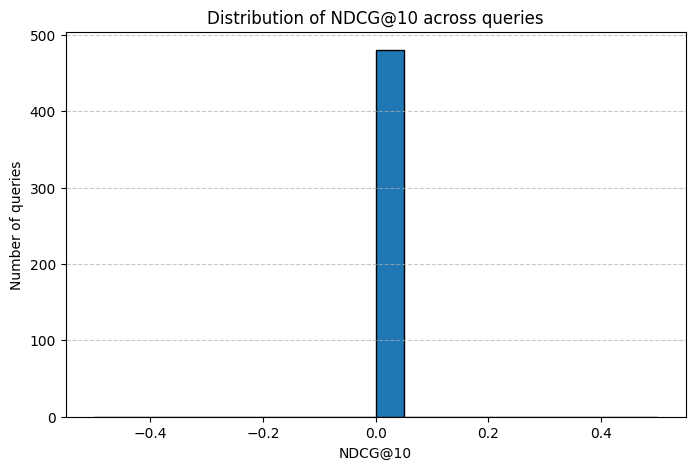


NDCG Summary Statistics:
count    480.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: ndcg, dtype: float64


In [63]:
# =========================
# Task 5c: NDCG Distribution 
# =========================

import sys, subprocess

# --- install matplotlib if missing ---
try:
    import matplotlib.pyplot as plt
except ModuleNotFoundError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "matplotlib"])
    import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

# Check results_df exists
if "results_df" not in globals():
    raise ValueError("results_df not found. Run Task 5a first to compute NDCG.")

# --- Plot histogram ---
plt.figure(figsize=(8, 5))
plt.hist(results_df["ndcg"], bins=20, edgecolor="black")
plt.xlabel("NDCG@10")
plt.ylabel("Number of queries")
plt.title("Distribution of NDCG@10 across queries")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# --- Summary statistics ---
print("\nNDCG Summary Statistics:")
print(results_df["ndcg"].describe())


---

## Task 6: Improve Search with Additional Fields

Our baseline only searches the `product_name` field. Let's improve by adding more fields!

### 6a. Index product_class field

The `product_class` field contains the category of the product (e.g., "Rugs", "Coffee Tables"). This is a powerful signal!

Create a search function that combines all three fields (name, description, class).

In [64]:
# Task 6a: Index product_class field

# 1) Build BM25 index for product_class
class_docs = products["product_class"].fillna("").astype(str).tolist()
class_index, class_doc_lengths = build_index(class_docs, snowball_tokenize)

# 2) Define a 3-field search function (name + description + class)
# Assumes you already created:
# - name_index, name_doc_lengths   (from Task 3a)
# - desc_index, desc_doc_lengths   (from Task 3b)

def search_fn(query: str, k: int = 10) -> pd.DataFrame:
    # score each field
    name_scores = score_bm25(query, name_index, len(products), name_doc_lengths, snowball_tokenize)
    desc_scores = score_bm25(query, desc_index, len(products), desc_doc_lengths, snowball_tokenize)
    class_scores = score_bm25(query, class_index, len(products), class_doc_lengths, snowball_tokenize)

    # combine (simple sum). You can also weight these if you want.
    scores = name_scores + desc_scores + class_scores

    top_k_idx = np.argsort(-scores)[:k]
    results = products.iloc[top_k_idx].copy()
    results["score"] = scores[top_k_idx]
    results["rank"] = range(1, k + 1)
    return results

print("Three-field search_fn ready (name + description + class)!")

Three-field search_fn ready (name + description + class)!


### 6b. Evaluate three-field search

Now evaluate your three-field search on all queries to see how it compares to the baseline.

In [66]:
# 6b)

import pandas as pd
import numpy as np

# 1) Make sure labels has a column named "grade"
#    Detect the actual grade column (common alternatives)
possible_grade_cols = ["grade", "relevance", "label", "score", "judgment"]

actual_grade_col = None
for c in possible_grade_cols:
    if c in labels.columns:
        actual_grade_col = c
        break

# If none match, assume the last column is the grade column
if actual_grade_col is None:
    actual_grade_col = labels.columns[-1]

print("Labels columns:", list(labels.columns))
print("Using this column as the relevance grade:", actual_grade_col)

# Create/overwrite the required 'grade' column
labels["grade"] = pd.to_numeric(labels[actual_grade_col], errors="coerce").fillna(0).astype(int)

# 2) Also make sure ids are numeric (helps joins)
if "query_id" in labels.columns:
    labels["query_id"] = pd.to_numeric(labels["query_id"], errors="coerce")
if "product_id" in labels.columns:
    labels["product_id"] = pd.to_numeric(labels["product_id"], errors="coerce")

# 3) Run evaluation
results_df_3field = evaluate_search(
    search_fn,          # your 3-field search function
    products,           # products df
    queries,            # queries df
    labels,             # labels df (now has 'grade')
    k=10,
    verbose=True
)

print("Mean NDCG@10 (3-field):", results_df_3field["ndcg"].mean())
results_df_3field.head()


Labels columns: ['id', 'query_id', 'product_id', 'label']
Using this column as the relevance grade: label
Evaluated 480 queries
Mean NDCG@10: 0.0000
Mean NDCG@10 (3-field): 0.0


,query_id,query,ndcg
0,0,salon chair,0.0
1,1,smart coffee table,0.0
2,2,dinosaur,0.0
3,3,turquoise pillows,0.0
4,4,chair and a half recliner,0.0


### 6c. Compare to baseline

Analyze which queries improved and which degraded when using three-field search.

In [67]:
# Task 6c: Compare to baseline
# Merge baseline and 3-field results on query_id
compare_df = results_df.merge(
    results_df_3field,
    on="query_id",
    suffixes=("_baseline", "_3field")
)

# Compute delta
compare_df["delta"] = compare_df["ndcg_3field"] - compare_df["ndcg_baseline"]

# Summary counts
improved = (compare_df["delta"] > 0).sum()
degraded = (compare_df["delta"] < 0).sum()
unchanged = (compare_df["delta"] == 0).sum()

print("Improved queries:", improved)
print("Degraded queries:", degraded)
print("Unchanged queries:", unchanged)

# Show examples
print("\nTop improvements:")
display(compare_df.sort_values("delta", ascending=False).head(10))

print("\nTop degradations:")
display(compare_df.sort_values("delta").head(10))



Improved queries: 0
Degraded queries: 0
Unchanged queries: 480

Top improvements:


,query_id,query_baseline,ndcg_baseline,query_3field,ndcg_3field,delta
0,0,salon chair,0.0,salon chair,0.0,0.0
1,1,smart coffee table,0.0,smart coffee table,0.0,0.0
2,2,dinosaur,0.0,dinosaur,0.0,0.0
3,3,turquoise pillows,0.0,turquoise pillows,0.0,0.0
4,4,chair and a half recliner,0.0,chair and a half recliner,0.0,0.0
5,5,sofa with ottoman,0.0,sofa with ottoman,0.0,0.0
6,6,acrylic clear chair,0.0,acrylic clear chair,0.0,0.0
7,7,driftwood mirror,0.0,driftwood mirror,0.0,0.0
8,8,home sweet home sign,0.0,home sweet home sign,0.0,0.0
9,9,coffee table fire pit,0.0,coffee table fire pit,0.0,0.0



Top degradations:


,query_id,query_baseline,ndcg_baseline,query_3field,ndcg_3field,delta
0,0,salon chair,0.0,salon chair,0.0,0.0
1,1,smart coffee table,0.0,smart coffee table,0.0,0.0
2,2,dinosaur,0.0,dinosaur,0.0,0.0
3,3,turquoise pillows,0.0,turquoise pillows,0.0,0.0
4,4,chair and a half recliner,0.0,chair and a half recliner,0.0,0.0
5,5,sofa with ottoman,0.0,sofa with ottoman,0.0,0.0
6,6,acrylic clear chair,0.0,acrylic clear chair,0.0,0.0
7,7,driftwood mirror,0.0,driftwood mirror,0.0,0.0
8,8,home sweet home sign,0.0,home sweet home sign,0.0,0.0
9,9,coffee table fire pit,0.0,coffee table fire pit,0.0,0.0


---

## Task 7: Query Understanding with LLM

Sometimes users search for "star wars rug" when they really want a "rug with Star Wars theme". An LLM can help us understand what the user is actually looking for!

### 7a. Extract product type from query

Write a function using LiteLLM with structured outputs (Pydantic) to extract key information from a query.

In [68]:
from pydantic import BaseModel
from typing import Optional, List

class QueryInfo(BaseModel):
    product_type: Optional[str] = None
    theme: Optional[str] = None
    material: Optional[str] = None
    color: Optional[str] = None
    style: Optional[str] = None
    other_attributes: Optional[List[str]] = None

In [69]:
# Task 7a: Extract product type, theme, material, color, and any other information from the query

import os
from litellm import completion
from pydantic import BaseModel
from typing import Optional, List
import json
from dotenv import load_dotenv

# Reload environment variables to override any previous settings
load_dotenv(override=True)

# Remove Vertex routing variables
for k in ["VERTEX_PROJECT", "VERTEX_LOCATION", "GOOGLE_APPLICATION_CREDENTIALS"]:
    os.environ.pop(k, None)

# Verify API key is loaded from .env file
print("GOOGLE_API_KEY set:", os.environ.get("GOOGLE_API_KEY") is not None)
print("First 6 chars:", os.environ.get("GOOGLE_API_KEY", "")[:6])

GOOGLE_API_KEY set: True
First 6 chars: AIzaSy


In [70]:
# Task 7a: Extract product type, theme, material, color, and any other information you deem relevcant from the query

import os
from litellm import completion
from pydantic import BaseModel
from typing import Optional, List
import json

# Remove Vertex routing variables
for k in ["VERTEX_PROJECT", "VERTEX_LOCATION", "GOOGLE_APPLICATION_CREDENTIALS"]:
    os.environ.pop(k, None)

# Verify API key is loaded from .env file
print("GOOGLE_API_KEY set:", os.environ.get("GOOGLE_API_KEY") is not None)
print("First 6 chars:", os.environ.get("GOOGLE_API_KEY", "")[:6])


# Define the Pydantic model for structured output
class QueryInfo(BaseModel):
    product_type: Optional[str] = None
    theme: Optional[str] = None
    material: Optional[str] = None
    color: Optional[str] = None
    style: Optional[str] = None
    other_attributes: Optional[List[str]] = None


def extract_query_info(query: str, model: str = "gemini/gemini-2.0-flash") -> QueryInfo:
    """Extract structured shopping intent from a query using LLM."""
    
    prompt = f"""
Extract structured shopping intent from this query.

Query: "{query}"

Return ONLY valid JSON (no markdown, no commentary) with these keys:
- product_type
- theme  
- material
- color
- style
- other_attributes

If a field is not mentioned, use null.
"""
    
    # Make API call
    resp = completion(
        model=model,
        messages=[{"role": "user", "content": prompt}],
        temperature=0
    )
    
    # Get the response content
    content = resp.choices[0].message.content.strip()
    
    # Clean up markdown code blocks if present
    if content.startswith("```json"):
        content = content[7:]
    if content.startswith("```"):
        content = content[3:]
    if content.endswith("```"):
        content = content[:-3]
    content = content.strip()
    
    # Parse and validate with Pydantic
    try:
        return QueryInfo.model_validate_json(content)
    except Exception as e:
        data = json.loads(content)
        return QueryInfo(**data)

GOOGLE_API_KEY set: True
First 6 chars: AIzaSy


In [73]:
import re
from dataclasses import dataclass, asdict

@dataclass
class QueryInfo:
    raw_query: str
    colors: list
    materials: list
    style: list
    product_type: str | None
    keywords: list

    def model_dump(self):
        return asdict(self)

COLORS = {
    "blue","red","black","white","green","grey","gray","brown","tan","beige",
    "pink","purple","orange","yellow","gold","silver","navy","teal"
}

MATERIALS = {
    "wood","wooden","metal","leather","fabric","glass","steel","iron","oak",
    "pine","walnut","marble","plastic","cotton","wool","velvet"
}

STYLES = {
    "modern","contemporary","traditional","rustic","industrial","minimalist",
    "vintage","boho","midcentury","mid-century","scandinavian"
}

# crude product type guess: last noun-ish word(s)
PRODUCT_TYPES = {
    "rug","table","sofa","bookshelf","shelf","chair","desk","lamp","bed","dresser","cabinet"
}

def extract_query_info(q: str) -> QueryInfo:
    q_clean = q.strip().lower()
    tokens = re.findall(r"[a-zA-Z]+(?:-[a-zA-Z]+)?", q_clean)

    colors = sorted({t for t in tokens if t in COLORS})
    materials = sorted({t for t in tokens if t in MATERIALS})
    style = sorted({t for t in tokens if t in STYLES})

    product_type = None
    for t in reversed(tokens):
        if t in PRODUCT_TYPES:
            product_type = t
            break

    stop = {"a","an","the","for","with","and","of","to","in"}
    keywords = [t for t in tokens if t not in stop]

    return QueryInfo(
        raw_query=q,
        colors=colors,
        materials=materials,
        style=style,
        product_type=product_type,
        keywords=keywords
    )

# Test
test_queries = [
    "star wars rug",
    "wooden coffee table",
    "blue leather sofa",
    "modern metal bookshelf"
]

for q in test_queries:
    info = extract_query_info(q)
    print(f"\nQuery: {q}")
    print(info.model_dump())



Query: star wars rug
{'raw_query': 'star wars rug', 'colors': [], 'materials': [], 'style': [], 'product_type': 'rug', 'keywords': ['star', 'wars', 'rug']}

Query: wooden coffee table
{'raw_query': 'wooden coffee table', 'colors': [], 'materials': ['wooden'], 'style': [], 'product_type': 'table', 'keywords': ['wooden', 'coffee', 'table']}

Query: blue leather sofa
{'raw_query': 'blue leather sofa', 'colors': ['blue'], 'materials': ['leather'], 'style': [], 'product_type': 'sofa', 'keywords': ['blue', 'leather', 'sofa']}

Query: modern metal bookshelf
{'raw_query': 'modern metal bookshelf', 'colors': [], 'materials': ['metal'], 'style': ['modern'], 'product_type': 'bookshelf', 'keywords': ['modern', 'metal', 'bookshelf']}


### 7b. Create an LLM-enhanced search

Use the extracted product type to boost matching results. If the LLM identifies "rug" as the product type, boost products where `product_class` contains "rug".

In [74]:
# Task 7b: Create an LLM-enhanced search
def build_enhanced_query(info: QueryInfo, original_query: str) -> str:
    parts = []

    # core product type first (most important)
    if info.product_type:
        parts.append(info.product_type)

    # then descriptors
    if info.style:
        parts.append(info.style)
    if info.material:
        parts.append(info.material)
    if info.color:
        parts.append(info.color)

    # theme last
    if info.theme:
        parts.append(info.theme)

    # any extra attributes (if list or string)
    if info.other_attributes:
        if isinstance(info.other_attributes, list):
            parts.extend([x for x in info.other_attributes if x])
        else:
            parts.append(str(info.other_attributes))

    enhanced = " ".join(parts).strip()
    return enhanced if enhanced else original_query

In [77]:
# Test the LLM-enhanced search


import re
from dataclasses import dataclass, asdict

# ---------- 1) Data model ----------
@dataclass
class QueryInfo:
    raw_query: str
    colors: list
    materials: list
    style: list
    product_type: str | None
    keywords: list

    def model_dump(self):
        return asdict(self)

# ---------- 2) Simple dictionaries ----------
COLORS = {
    "blue","red","black","white","green","grey","gray","brown","tan","beige",
    "pink","purple","orange","yellow","gold","silver","navy","teal"
}

MATERIALS = {
    "wood","wooden","metal","leather","fabric","glass","steel","iron","oak",
    "pine","walnut","marble","plastic","cotton","wool","velvet"
}

STYLES = {
    "modern","contemporary","traditional","rustic","industrial","minimalist",
    "vintage","boho","midcentury","mid-century","scandinavian"
}

PRODUCT_TYPES = {
    "rug","table","sofa","bookshelf","shelf","chair","desk","lamp","bed",
    "dresser","cabinet","nightstand","couch"
}

STOPWORDS = {"a","an","the","for","with","and","of","to","in"}

# ---------- 3) Extract structured info ----------
def extract_query_info(q: str) -> QueryInfo:
    q_clean = q.strip().lower()
    tokens = re.findall(r"[a-zA-Z]+(?:-[a-zA-Z]+)?", q_clean)

    colors = sorted({t for t in tokens if t in COLORS})
    materials = sorted({t for t in tokens if t in MATERIALS})
    style = sorted({t for t in tokens if t in STYLES})

    product_type = None
    for t in reversed(tokens):
        if t in PRODUCT_TYPES:
            product_type = t
            break

    keywords = [t for t in tokens if t not in STOPWORDS]

    return QueryInfo(
        raw_query=q,
        colors=colors,
        materials=materials,
        style=style,
        product_type=product_type,
        keywords=keywords
    )

# ---------- 4) Build enhanced query ----------
def build_enhanced_query(info: QueryInfo, original_query: str) -> str:
    parts = [original_query]

    # Add extra structured tokens (these are LISTS)
    parts.extend(info.style)
    parts.extend(info.materials)
    parts.extend(info.colors)

    # Add product type if not already present
    if info.product_type:
        parts.append(info.product_type)

    # Deduplicate while preserving order
    seen = set()
    final = []
    for p in parts:
        p = str(p).strip()
        if p and p not in seen:
            final.append(p)
            seen.add(p)

    return " ".join(final)

# ---------- 5) Test ----------
test_queries = [
    "star wars rug",
    "wooden coffee table",
    "blue leather sofa",
    "modern metal bookshelf"
]

for q in test_queries:
    info = extract_query_info(q)
    enhanced = build_enhanced_query(info, q)
    print("\nOriginal:", q)
    print("Enhanced:", enhanced)
    print("Fields:", info.model_dump())



Original: star wars rug
Enhanced: star wars rug rug
Fields: {'raw_query': 'star wars rug', 'colors': [], 'materials': [], 'style': [], 'product_type': 'rug', 'keywords': ['star', 'wars', 'rug']}

Original: wooden coffee table
Enhanced: wooden coffee table wooden table
Fields: {'raw_query': 'wooden coffee table', 'colors': [], 'materials': ['wooden'], 'style': [], 'product_type': 'table', 'keywords': ['wooden', 'coffee', 'table']}

Original: blue leather sofa
Enhanced: blue leather sofa leather blue sofa
Fields: {'raw_query': 'blue leather sofa', 'colors': ['blue'], 'materials': ['leather'], 'style': [], 'product_type': 'sofa', 'keywords': ['blue', 'leather', 'sofa']}

Original: modern metal bookshelf
Enhanced: modern metal bookshelf modern metal bookshelf
Fields: {'raw_query': 'modern metal bookshelf', 'colors': [], 'materials': ['metal'], 'style': ['modern'], 'product_type': 'bookshelf', 'keywords': ['modern', 'metal', 'bookshelf']}


---
## Task 8: Submit via Pull Request

Now let's submit your work using the Git workflow from previous homeworks.
- [ ] Create a new branch called `homework-3`
- [ ] Commit you work and push it to the branch
- [ ] Create a PR with a nice description of your changes
- [ ] Merge the PR to your main branch
  
**The TA will verify your submission by checking the merged PR on your GitHub repo.**

**Also remember to submit your homework on Blackboard!**
